# Pytroch

**PyTorch** — это фреймворк для языка программирования Python, предназначенный для машинного обучения. Он включает в себя набор инструментов для работы с моделями, используется в обработке естественного языка, компьютерном зрении и других похожих направлениях.

Ключевые особенности:
* Динамические вычисления
* Автоматическое дифференцирование
* Работает на GPU из коробки

В **Pytroch** основным типом данных являются тензоры, которые представляют собой многомерные массивы. Тензоры очень похожи на __numpy.array__

# Устанавливаем зависимости

In [1]:
!pip install torch torchvision numpy matplotlib pandas tqdm -q
!pip install --upgrade ipywidgets jupyter -q
!pip install torchsummary


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Импортируем необходимые библиотеки

In [3]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Фиксируем random seed, чтобы эксперименты были воспроизводимы
torch.manual_seed(0)
np.random.seed(0)

# Dataset

**Dataset** в Pytorch позволяет организовать данные перед подачей на вход модели.

Обязательно должны быть три метода: `__init__`, `__len__` и `__getitem__`.
1. `__init__` - говорим откуда брать данные.
2. `__len__` - возвращает количество элементов в датасете.
3. `__getitem__` - возвращает один элемент датасета по индексу. Обычно здесь говорим, как преобразовать данные


В данном примере:
* В `__init__`:
    * Указали путь к директориям и сразу считали оттуда данные.
    * Добавили класс для картинки
* В `__len__`:
    * вернули общее количество картинок
* В `__getitem__`:
    * Подготовили данные: выполнили Resize, нормализацию, **преобразовали в тензор (обязательно!)**
    * Вернули картинку и ее класс

В итоге, при итерации по датасету, мы получаем картинку в виде тензора и ее класс.

In [4]:
#load the data
class HandwrittenDigitDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Инициализация датасета.

        :param root_dir: Корневая директория с поддиректориями для каждой цифры.
        :param transform: Преобразования, применяемые к изображениям.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Проходим по всем поддиректориям в корневой директории
        for label in os.listdir(root_dir):
            digit_dir = os.path.join(root_dir, label)
            if os.path.isdir(digit_dir):
                for img_file in os.listdir(digit_dir):
                    if img_file.endswith('.png'):
                        self.image_paths.append(os.path.join(digit_dir, img_file))
                        self.labels.append(int(label))

    def __len__(self):
        """Возвращает количество элементов в датасете."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Получает элемент по индексу.

        :param idx: Индекс элемента.
        :return: Кортеж (изображение, метка).
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

In [5]:
# Пример использования
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Приводим к размеру 28x28. В данном случае можно и без него
    transforms.ToTensor(),         # Преобразуем в тензор
    transforms.Normalize((0.5,), (0.5,))  # Нормализуем изображения. Повышает скорость обучения
])

# Задаем пути к директориям train и test
train_dataset = HandwrittenDigitDataset(root_dir='data/train', transform=transform)
test_dataset = HandwrittenDigitDataset(root_dir='data/test', transform=transform)

# Dataloader

**Dataloader** отвечает за сбор данных в батч и за манипуляции с данными в рамказ одного батча.

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Пример

In [7]:
# Пример получения одного изображения и его метки
image, label = train_dataset[0]
print(f'Label: {label}, Image size: {image.size()}')

# Пример перебора батчей из DataLoader
for images, labels in train_loader:
    print(f'Batch of images: {images.size()}, Batch of labels: {labels.size()}')
    break  # Убрать break, чтобы перебрать все батчи

Label: 9, Image size: torch.Size([1, 28, 28])
Batch of images: torch.Size([32, 1, 28, 28]), Batch of labels: torch.Size([32])


In [8]:
# Посмотрим на одно изображение в виде матрицы
df = pd.DataFrame(image[0].numpy())
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
5,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
6,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.913725,-0.733333,0.662745,0.984314,0.654902,-0.325490,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
7,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.364706,0.592157,0.984314,0.976471,0.976471,0.976471,0.976471,-0.827451,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
8,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.647059,0.200000,0.882353,0.976471,0.984314,0.976471,0.976471,0.976471,0.976471,0.145098,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
9,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.850980,0.850980,0.976471,0.976471,0.976471,0.984314,0.349020,-0.647059,-0.309804,0.913725,0.874510,-0.733333,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


0 7 9 0 8 3 2 0 
7 5 1 9 4 2 3 0 
3 4 3 9 2 5 5 4 
7 5 4 1 8 4 0 5 


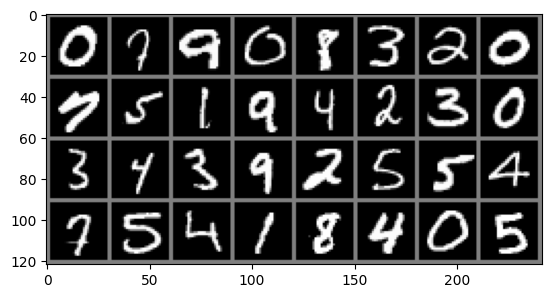

In [9]:
# Посмотрим на несколько изображений из датасета вместе с классами
def imshow(img):
    npimg = (img.numpy() + 1) / 2 # unnormalize
    plt.imshow(np.transpose(npimg, (1,2,0)))

imshow(torchvision.utils.make_grid(images))
for i in range(train_loader.batch_size):
    print(labels.numpy()[i], end=' ')
    if i % 8 == 7:
        print()

# Простая Convolutional Neural Network

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=0)  # Слой свертки
        self.relu1 = nn.ReLU()  # Слой активации
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Maxpool
        self.fc1 = nn.Linear(32 * 12 * 12, 10)  # Полносвязный слой

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x) 
        x = self.pool(x)
        x = torch.flatten(x, 1) 
        x = self.fc1(x)
        return x

In [22]:
# быстро проверить, что все работает
summary(SimpleCNN(), image.size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
         MaxPool2d-3           [-1, 32, 12, 12]               0
            Linear-4                   [-1, 10]          46,090
Total params: 46,922
Trainable params: 46,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.18
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


# Обучение модели

In [23]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    for epoch in tqdm(range(num_epochs), desc="Epochs", leave=False):
        model.train()  # Устанавливаем модель в режим обучения
        running_loss = 0.0

        # Обучение модели
        for images, labels in tqdm(train_loader, desc="Processing train batches", leave=False):
            optimizer.zero_grad()  # Обнуляем градиенты
            outputs = model(images)  # Прямой проход
            loss = criterion(outputs, labels)  # Вычисление потерь
            loss.backward()  # Обратный проход
            optimizer.step()  # Обновление весов

            running_loss += loss.item()  # Суммируем потери

        # Считаем средний лосс на обучающей выборке
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Оценка на тестовой выборке
        model.eval()  # Установим модель в режим оценки
        with torch.no_grad():  # Отключаем подсчет градиентов
            test_loss = 0.0
            correct = 0
            total = 0
            for images, labels in tqdm(test_loader, desc="Processing test batches", leave=False):
                outputs = model(images)  # Прямой проход
                loss = criterion(outputs, labels)  # Вычисление потерь
                test_loss += loss.item()  # Суммируем потери

                # Для расчета точности
                _, predicted = torch.max(F.log_softmax(outputs.data, dim=1), 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Считаем средний лосс на тестовом наборе
            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)
            accuracy = 100 * correct / total
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, '
                  f'Accuracy: {accuracy:.2f}%')

    return train_losses, test_losses

In [ ]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 4

In [27]:
# запускаем обучение. 
train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Processing train batches:   0%|          | 0/1875 [00:00<?, ?it/s]

Processing test batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 0.1471, Test Loss: 0.0703, Accuracy: 97.70%


Processing train batches:   0%|          | 0/1875 [00:00<?, ?it/s]

Processing test batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [2/5], Train Loss: 0.0631, Test Loss: 0.0504, Accuracy: 98.30%


Processing train batches:   0%|          | 0/1875 [00:00<?, ?it/s]

Processing test batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [3/5], Train Loss: 0.0471, Test Loss: 0.0524, Accuracy: 98.31%


Processing train batches:   0%|          | 0/1875 [00:00<?, ?it/s]

Processing test batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [4/5], Train Loss: 0.0364, Test Loss: 0.0570, Accuracy: 98.24%


Processing train batches:   0%|          | 0/1875 [00:00<?, ?it/s]

Processing test batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [5/5], Train Loss: 0.0302, Test Loss: 0.0514, Accuracy: 98.49%


# Визуализируем Loss

In [28]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid()
    plt.show()

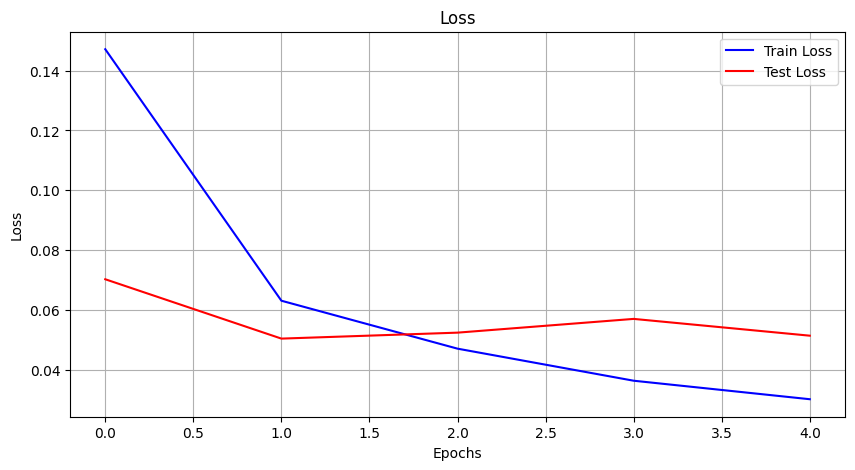

In [29]:
plot_losses(train_losses, test_losses)

# Смотрим предсказания

In [30]:
images, labels = next(iter(test_loader))

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

In [35]:
df = pd.DataFrame({'True': labels, 'Predictions': predicted})
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
True,5,4,3,3,1,8,0,7,1,9
Predictions,5,4,3,3,1,8,0,3,1,9


In [43]:
image = images[7]
df = pd.DataFrame(image[0].numpy())
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
5,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
6,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.678431,0.937255,0.584314,-0.984314,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
7,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.803922,0.639216,0.890196,-0.341176,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
8,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.505882,0.435294,0.992157,-0.349020,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
9,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.874510,-1.000000,-0.992157,-0.129412,0.866667,0.003922,0.741176,-0.145098,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


# Дополнительные материалы

- Документация Pytroch: https://pytorch.org/tutorials/
- Объяснение про CNN от Яндекса: https://education.yandex.ru/handbook/ml/article/svyortochnye-nejroseti
